The states derivative is: [9.9 1.496 -1.004 2.587 0.1 1.0 0.1]

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     2473
Number of nonzeros in inequality constraint Jacobian.:      320
Number of nonzeros in Lagrangian Hessian.............:     3762

Total number of variables............................:      722
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      722
                     variables with only upper bounds:        0
Total number of equality cons

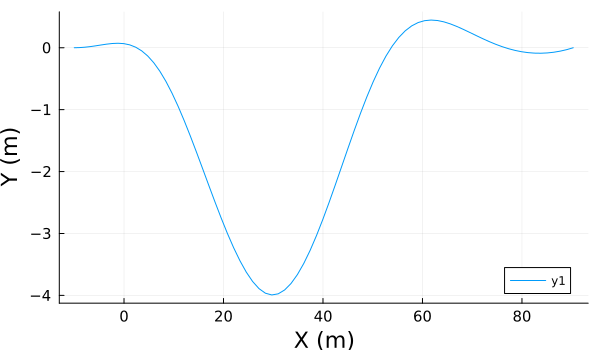

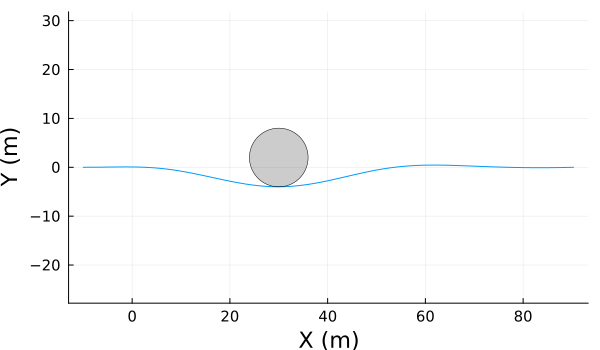

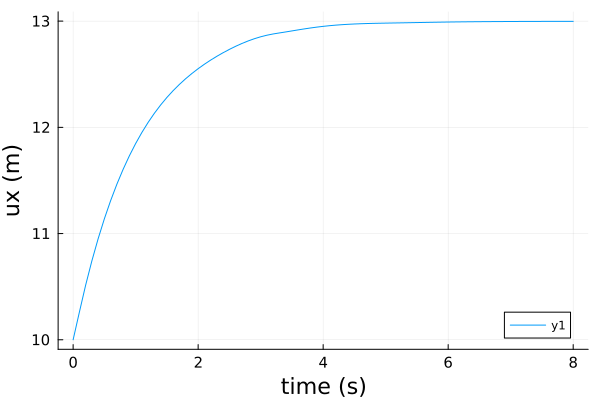

In [1]:
using JuMP
using Ipopt
using Plots
include("Q2c_VehicleDynamics.jl")

function circleShape(h,k,r)
    θ = LinRange(0, 2*π, 500)
    h.+r*sin.(θ), k.+r*cos.(θ)
end

x0 = [-10.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0] #TODO Initial Condition
XL = [-40, -20, -3, -pi/5,  -pi/2, 5.0, -pi/12] # States Lower Bound
XU = [300, 20, 3, pi/5, pi/2, 15.0, pi/12] #TODO States Upper Bound
CL = [-2.6, -0.1] #TODO Control Lower Bound
CU = [2.6, 0.1] #TODO Control Upper Bound

model = Model(optimizer_with_attributes(Ipopt.Optimizer)) # Initialize JuMP model

numStates = 7 #TODO number of states
numControls = 2 #TODO number of control
PredictionHorizon = 8 #TODO Prediction Time
numColPoints = 81 #TODO 
Δt = PredictionHorizon/(numColPoints - 1)# Time interval

@variables(model, begin
    # Set xst as a numColPoints x numStates matrix that is 
    # between the upper and lower states bounds
    XL[i] ≤ xst[j in 1:numColPoints, i in 1:numStates]  ≤ XU[i]
    #TODO Set u as a numColPoints x numControls matrix that is between the
    #  upper and lower control bounds
    CL[i] ≤ u[j in 1:numColPoints, i in 1:numControls] ≤ CU[i]
end)


fix(xst[1, 1], x0[1]; force = true) # set the initial condition for x-position value
#TODO Follow the same way, set the remaining initial conditions, set x0[2] to xst[1,2],... and so on.
fix(xst[1,2],x0[2];force = true)
fix(xst[1,3],x0[3];force = true)
fix(xst[1,4],x0[4];force= true)
fix(xst[1,5],x0[5];force= true)
fix(xst[1,6],x0[6];force= true)
fix(xst[1,7],x0[7];force= true)


x = xst[:, 1]; y = xst[:, 2]; v = xst[:, 3]; r = xst[:, 4]; ψ = xst[:, 5]; 
ux = xst[:, 6]; sa = xst[:, 7]; 
ax = u[:, 1]; # retract variable 
sr = u[:, 2]; 

# δxst = Matrix{Any}(undef, numColPoints, numStates)
# write the states derivative for all states & controls
δxst = Matrix{Any}(undef, numColPoints, numStates)
for i = 1:1:numColPoints
    δxst[i, :] = @expression(model, VehicleDynamics(xst[i, :], u[i, :]))
end

# add constraint to each state using backward Euler method
for j = 2:numColPoints
    for i = 1:numStates
        @constraint(model, xst[j, i] == xst[j - 1, i] +Δt * δxst[j, i])
    end
end


# TODO write the cost function for each term
y_cost = @expression(model, sum((y[j])^2 * Δt for j= 1:1:numColPoints)) #global y position of C.G Cost
sr_cost = @expression(model, sum((sr[j])^2 * Δt for j= 1:1:numColPoints))
sa_cost = @expression(model, sum((sa[j])^2 * Δt for j= 1:1:numColPoints))
ux_cost = @expression(model, sum((ux[j] - 13)^2 * Δt for j= 1:1:numColPoints))
ax_cost = @expression( model, sum((ax[j])^2 * Δt for j=1:1:numColPoints)) # ax cost



#TODO define cost weight
w_y  = 0.05 # change later for 2f
w_sr = 2.0
w_ax = 0.2
w_ux = 0.2
w_sa = 1.0


block_list = [30.0 2 6] # block_list = [obstacle_x_center, obstacle_y_center, radius]

# TODO add obstacle avoidance constraint
obs_constraint = @constraint(model, [i = 1:numColPoints], 
1 <=  ((x[i]-block_list[1])^2+(y[i]-block_list[2])^2)/(block_list[3])^2
)


#Solve
@objective(model, Min, w_y * y_cost + w_sr * sr_cost + w_ax * ax_cost + w_ux * ux_cost + w_sa * sa_cost) # objective value
# set_silent(model)  # Hide solver's verbose output
# @assert is_solved_and_feasible(model)
optimize!(model) # optimize model
StatesHis = value.(model[:xst]) # retrieve data


println("Your y cost is:  ", round(value(y_cost); digits = 3))

p = plot(size=(600, 350))
# plot!(p, StatesHis[:, 1], StatesHis[:, 2], tickfontsize = 10, xlabel = "X (m)", ylabel = "Y (m)",guidefont=15) # path plot
# plot!(p, circleShape(block_list[1], block_list[2], block_list[3]), seriestype = [:shape,], ;w = 0.5, c=:black, linecolor = :black, legend = false, fillalpha = 0.2, aspect_ratio=:equal)
# plot(0:Δt:PredictionHorizon, StatesHis[:, 6], tickfontsize = 10, xlabel = "time (s)", ylabel = "ux (m)",guidefont=15) # Speed plot

display(plot!(p, StatesHis[:, 1], StatesHis[:, 2], tickfontsize = 10, xlabel = "X (m)", ylabel = "Y (m)",guidefont=15))# path plot
display(plot!(p, circleShape(block_list[1], block_list[2], block_list[3]), seriestype = [:shape,], ;w = 0.5, c=:black, linecolor = :black, legend = false, fillalpha = 0.2, aspect_ratio=:equal))
display(plot(0:Δt:PredictionHorizon, StatesHis[:, 6], tickfontsize = 10, xlabel = "time (s)", ylabel = "ux (m)",guidefont=15)) # Speed plot
